In [1]:
# 2D Toy training example
# Goal: examine how the gradients change the center and sigma of a single neuron
# Conclusions: Center Gradients are correct (moves to the right center)

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
# random seeds
# torch.manual_seed(1665)
# np.random.seed(3266)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [6]:
!gpustat

crescent  Thu Sep 12 16:46:26 2019
[0] GeForce GTX 1080 | 60'C,  50 % |  2945 /  8119 MB | salami(2935M)
[1] GeForce GTX 1080 | 45'C,   0 % |    10 /  8119 MB |


In [7]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# manualy set cuda device
torch.cuda.set_device(1)

CUDA Available:  True


In [8]:
# Define 2d Toy Data

# number of dimensions of the data
num_dim = 2

# gaussian target parameters
data_centers = 1*np.ones(num_dim)
sigma = 1

# hyper-plane separating the classes (this will become the target for the weights)
sep_plane = np.random.uniform(low=-1.0, high=1.0, size=num_dim)
# sep_plane = np.concatenate(([1],np.zeros(num_dim-1)))

num_samples = 1000
stretch = [1.0, 3.0]

samples_xs = np.array([stretch*np.random.normal(loc=0, scale=sigma, size=num_dim)+data_centers for _ in range(num_samples)] )

# apply labels based on side of sep hyper plane
samples_labels = np.array([ [1] if x>np.matmul(data_centers, sep_plane) else [-1] for x in np.matmul(samples_xs, sep_plane)])

# shuffle in unison
permutation = np.random.permutation(len(samples_xs))
for old_index, new_index in enumerate(permutation):
    samples_xs[new_index] = samples_xs[old_index]
    samples_labels[new_index] = samples_labels[old_index]

<IPython.core.display.Javascript object>


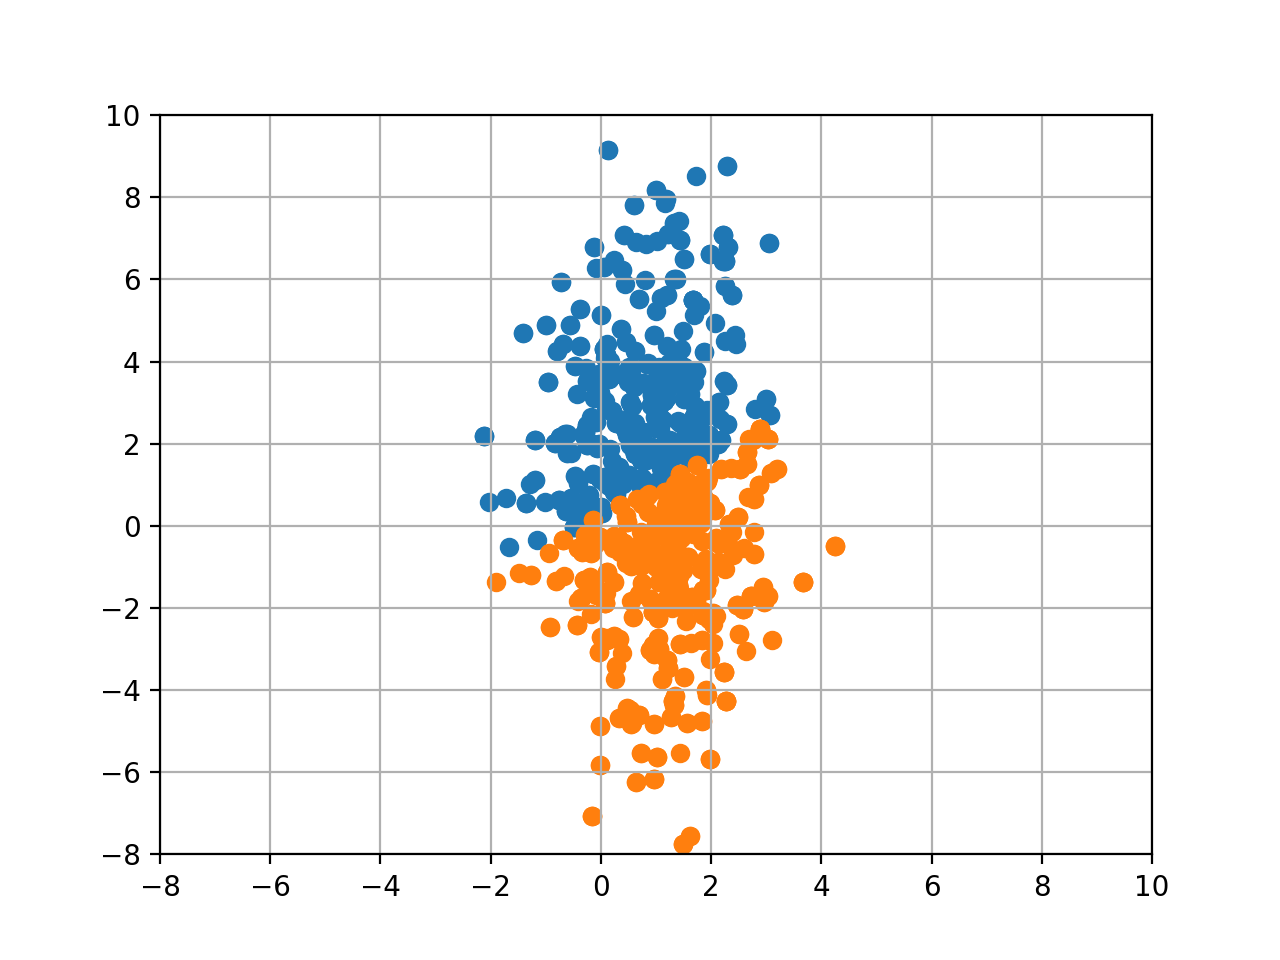

In [9]:
# 2D Check 
samples_x_1 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==1]
samples_y_1 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==1]

samples_x_2 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==-1]
samples_y_2 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==-1]

plt.scatter(samples_x_1, samples_y_1)
plt.scatter(samples_x_2, samples_y_2)
plt.axis([-8,10, -8,10])
plt.grid(True)
plt.show()

In [10]:
# convert data to pytorch format 
tensor_x = torch.Tensor(samples_xs)
tensor_y = torch.Tensor(samples_labels)

my_dataset = torch.utils.data.TensorDataset(tensor_x[:num_samples*4/5],tensor_y[:num_samples*4/5]) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_x[num_samples*4/5:],tensor_y[num_samples*4/5:]) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=32, shuffle=True) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data) # create your dataloader

In [11]:
# Define a Finite Gaussian Neural Network

covar_type = 'full'

class FGNet(nn.Module):
    def __init__(self):
        super(FGNet, self).__init__()
        self.l1 = fgnl.FGN_layer(2,1, covar_type=covar_type)

    def forward(self, x):
        x = self.l1(x)
        # clip res to +-1 for MSE loss
        x  = torch.clamp(x, min=-1.0, max=1.0)

        return x

In [12]:
# Initialize the network
model = FGNet().to(device)

In [13]:
model.state_dict()

OrderedDict([('l1.weights', tensor([[-0.8908,  0.1027]])),
             ('l1.centers', tensor([[-0.0475, -0.0726]])),
             ('l1.sigmas', tensor([[[1.4142, 0.0000],
                       [0.0000, 1.4142]]])),
             ('l1.inv_covar', tensor([[[0.7071, 0.0000],
                       [0.0000, 0.7071]]]))])

In [14]:
# increase range of neuron
model.l1.sigmas = torch.nn.Parameter(10.0*model.l1.sigmas)
if covar_type in ['sphere', 'diag']:
    model.l1.inv_covar = torch.nn.Parameter(1./model.l1.sigmas)
elif covar_type == 'full':
    model.l1.inv_covar = torch.nn.Parameter(model.l1.sigmas.inverse())


In [15]:
# model stats
print(model)
print([p.size() for p in list(model.parameters())])
# print([p for p in list(model.parameters())])
print("Training?", model.training) 
model.state_dict()

FGNet(
  (l1): FGN_layer()
)
[torch.Size([1, 2]), torch.Size([1, 2]), torch.Size([1, 2, 2]), torch.Size([1, 2, 2])]
Training? True


OrderedDict([('l1.weights', tensor([[-0.8908,  0.1027]])),
             ('l1.centers', tensor([[-0.0475, -0.0726]])),
             ('l1.sigmas', tensor([[[14.1421,  0.0000],
                       [ 0.0000, 14.1421]]])),
             ('l1.inv_covar', tensor([[[0.0707, -0.0000],
                       [0.0000, 0.0707]]]))])

In [16]:
# importances of the constraints
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
if covar_type == 'sphere':
    lmbda_sigs = 20.0*lmbda_l2
elif covar_type == 'diag':
    lmbda_sigs = 20.0*lmbda_l2
elif covar_type == 'full':
    lmbda_sigs = 50.0*lmbda_l2
    
print(lmbda_l2)
print(lmbda_sigs)

# loss function
def loss_func(model, output, target):
    
    # normal MSE loss
    mse_loss = F.mse_loss(output, target)
    
    # sum of sigma squares loss
    sig_loss = fgnl.sigmas_loss(model)

    # l2 loss
    l2_loss = fgnh.l2_loss(model)
    
    # (old) negative log likelihood over gaussian loss
#     nllg_loss = 100.0*lmbda*torch.sum(likelihood)
#     nllg_loss = 0.0*torch.mean(likelihood)
    
    return mse_loss +lmbda_l2*l2_loss  + lmbda_sigs*sig_loss 

0.0005
0.025


In [17]:
# number of correct pred function
def pred_func(output, target):
    # (old)split output into pred and likelihoods
#     output,_ = output
    pred = torch.Tensor.sign(output)
    correct = pred.eq(target.view_as(pred)).sum().item()   
    return correct

In [18]:
# model_optimizer
# optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1, momentum=0.5, nesterov=True)
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)
# optimizer = optim.Adagrad(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1)
optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), momentum=0.9)


In [19]:
epochs = 10
train_res = fgnh.train(model, my_dataloader, loss_func, optimizer, epochs, save_hist=2, verbose=True, pred_func=pred_func, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: 1.0031, Accuracy: 731/800 (91%)
Test set - Average loss: 0.9096, Accuracy: 195/200 (98%)
Epoch 1 Train set - Average loss: 0.8951, Accuracy: 775/800 (97%)
Test set - Average loss: 0.8988, Accuracy: 192/200 (96%)
Epoch 2 Train set - Average loss: 0.8686, Accuracy: 773/800 (97%)
Test set - Average loss: 0.8712, Accuracy: 191/200 (96%)
Epoch 3 Train set - Average loss: 0.8260, Accuracy: 778/800 (97%)
Test set - Average loss: 0.8013, Accuracy: 196/200 (98%)
Epoch 4 Train set - Average loss: 0.6838, Accuracy: 789/800 (99%)
Test set - Average loss: 0.5975, Accuracy: 197/200 (98%)
Epoch 5 Train set - Average loss: 0.4025, Accuracy: 787/800 (98%)
Test set - Average loss: 0.2888, Accuracy: 199/200 (100%)
Epoch 6 Train set - Average loss: 0.2443, Accuracy: 784/800 (98%)
Test set - Average loss: 0.1838, Accuracy: 198/200 (99%)
Epoch 7 Train set - Average loss: 0.1867, Accuracy: 788/800 (98%)
Test set - Average loss: 0.1923, Accuracy: 195/200 (98%)
Epoch 8 Train s

In [20]:
# print model state_dict post training
model.state_dict()

OrderedDict([('l1.weights', tensor([[-2.9791,  3.9572]])),
             ('l1.centers', tensor([[0.9289, 1.1408]])),
             ('l1.sigmas', tensor([[[14.1421,  0.0000],
                       [ 0.0000, 14.1421]]])),
             ('l1.inv_covar', tensor([[[ 0.5240,  0.0624],
                       [-0.0379,  0.2734]]]))])

<IPython.core.display.Javascript object>


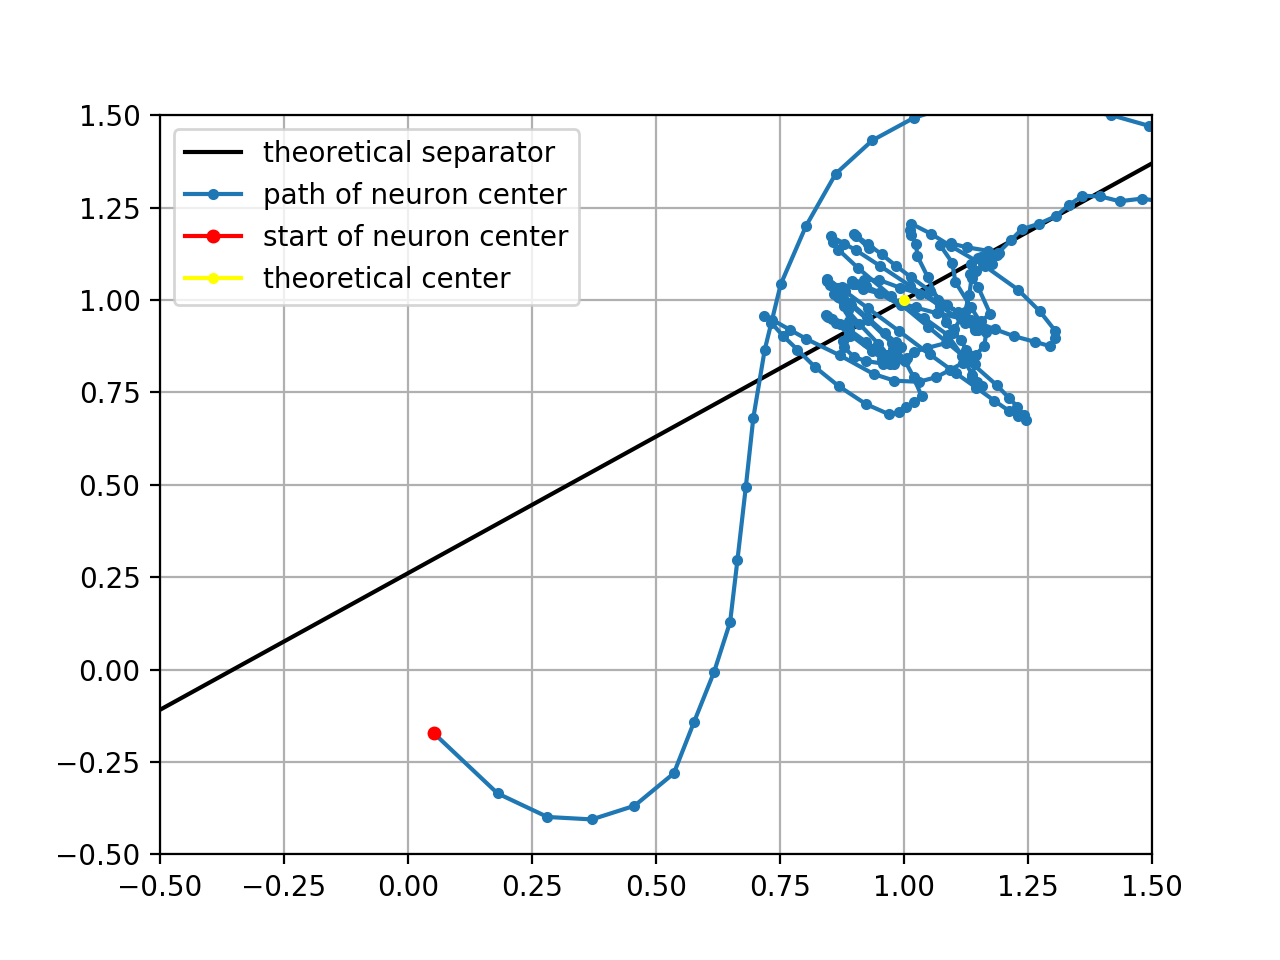

In [21]:
# compare center with target (1,1)

# plot the zero line
b = -np.matmul(sep_plane,data_centers)
X = np.arange(-0.5,1.6, 0.1)
zero_line = -(sep_plane[0]*X+b)/sep_plane[1]
plt.plot(X,zero_line, color='black', label='theoretical separator')

x, y = zip(*train_res['histories']['l1.centers'][:,0,:])
plt.plot(x,y, marker='.', linestyle='-', label='path of neuron center')

# plot start
x,y = train_res['histories']['l1.centers'][0,0,:]
plt.plot(x,y, marker='o', markersize=4, color="red", label='start of neuron center')
# plot target
x, y = 1,1
plt.plot(x,y, marker='.', linestyle='-', color="yellow", label='theoretical center')

plt.legend()
plt.axis([-0.5,1.5, -0.5,1.5])
plt.grid()
plt.show()

In [22]:
### old, no longer using sigma but inv covar
# # plot sigma history
# plt.plot(train_res['histories']['l1.sigmas'][:,0], marker='.', linestyle='-')
# plt.grid()
# plt.show()

l1.inv_covar
(251, 1, 2, 2)


<IPython.core.display.Javascript object>


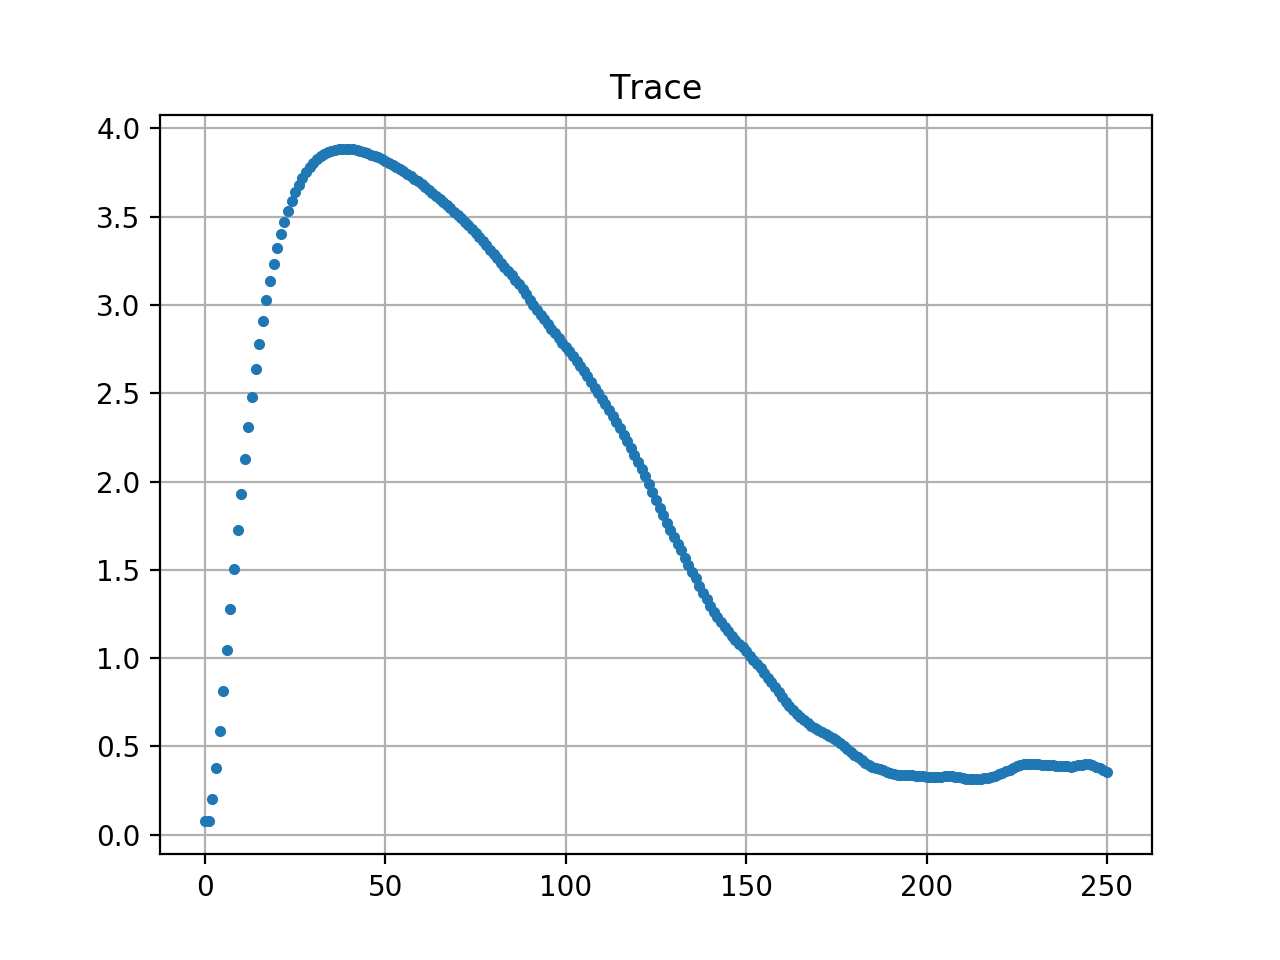

In [23]:
# check that inv covar has gone up, sigmas down, and trace down if covar_type=='full'
for k in train_res['histories'].keys():
    if 'inv_covar' in k:
        print(k)
        s = train_res['histories'][k].shape
        print(s)
        if covar_type == 'diag':
            # for each neuron
            for i in range(len(train_res['histories'][k][0])):
                plt.plot(train_res['histories'][k][:,i].reshape(s[0],np.prod(s[2:])), marker='.', linestyle=' ')
                plt.title('Inverse Covariance')
                plt.grid()
                plt.show()
                
                plt.plot(1.0/train_res['histories'][k][:,i].reshape(s[0],np.prod(s[2:])), marker='.', linestyle=' ')
                plt.title('Sigmas')
                plt.grid()
                plt.show()
        
        elif covar_type == 'full':
            # for each neuron
            for i in range(len(train_res['histories'][k][0])):
                # plot trace
                trace = [np.einsum('ik,ik->', p, p) for p in train_res['histories'][k][:,i]]
                plt.plot(trace, marker='.', linestyle=' ')
                plt.title('Trace')
                plt.grid()
                plt.show()
        
        
        else:
            # covar_type == 'sphere'
            plt.plot(train_res['histories'][k], marker='.', linestyle=' ',)
            plt.title('Inverse Covariance')
            plt.grid()
            plt.show()
            
            plt.plot(1.0/train_res['histories'][k], marker='.', linestyle=' ')
            plt.title('Sigma')

            plt.grid()
            plt.show()

<IPython.core.display.Javascript object>


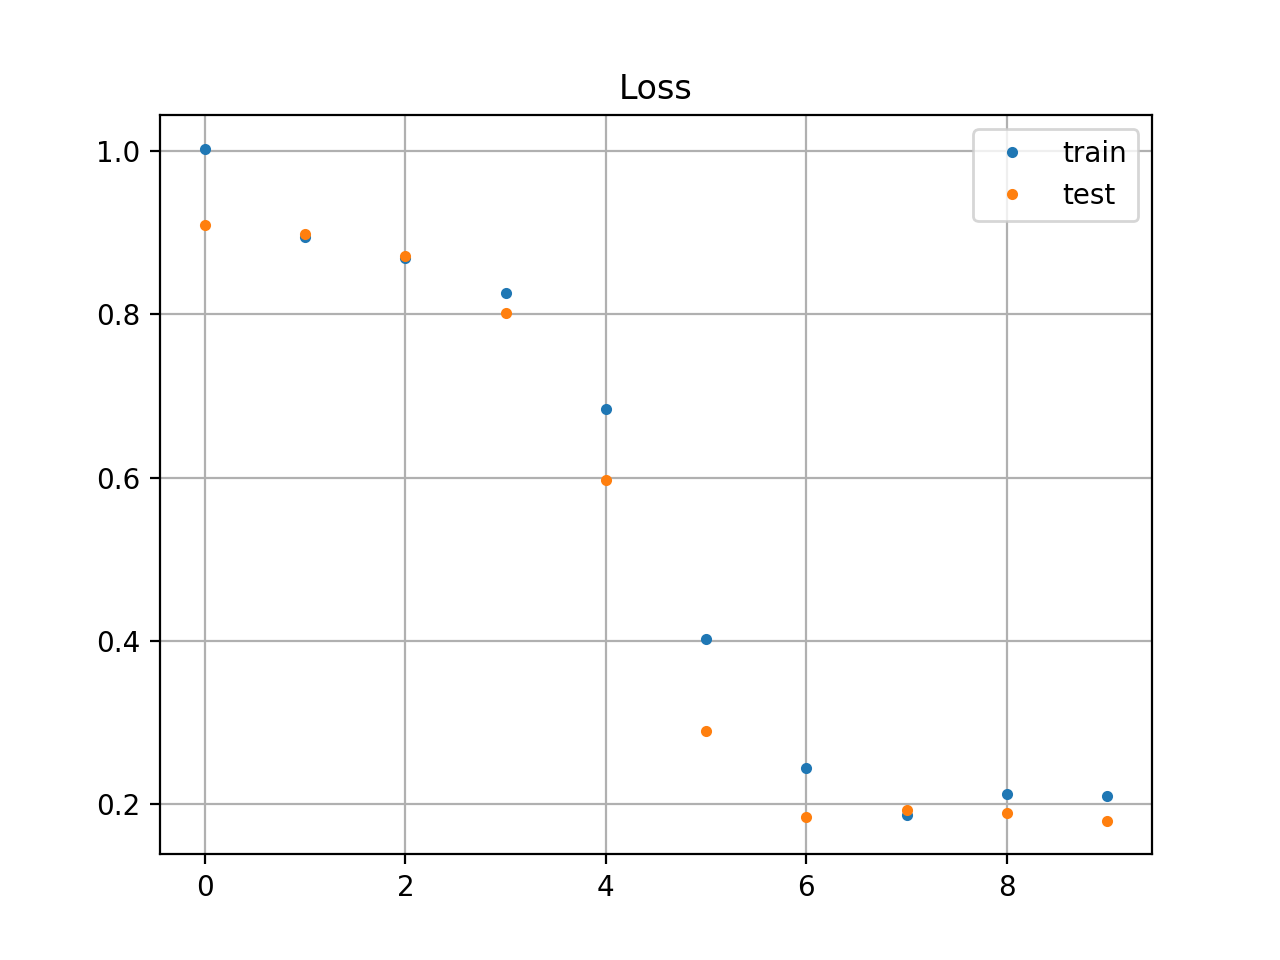

<IPython.core.display.Javascript object>


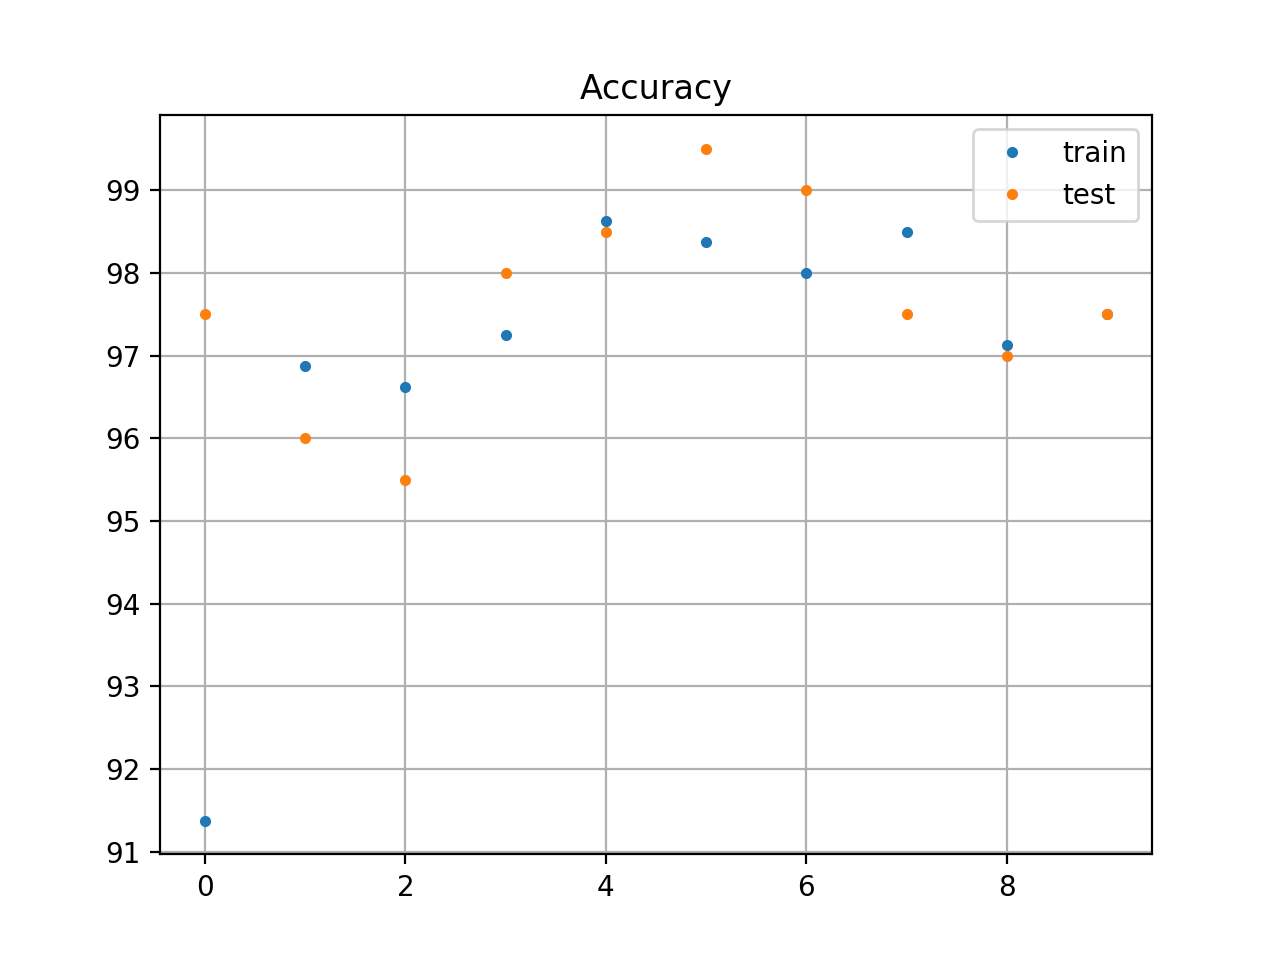

In [24]:
# acc and loss hist
plt.plot(train_res['train_loss_hist'], marker='.', linestyle=' ', label='train')
plt.plot(train_res['test_loss_hist'], marker='.', linestyle=' ', label='test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(train_res['train_acc_hist'], marker='.', linestyle=' ', label='train')
plt.plot(train_res['test_acc_hist'], marker='.', linestyle=' ', label='test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

weights: [-2.9791346  3.957241 ]
center: [0.9288968 1.1407776]
bias: -1.7470233
inv covar: [[ 0.52401334  0.06240771]
 [-0.03791074  0.2734229 ]]
sig: [[ 3.4128978 -2.3461401]
 [ 1.425207  12.833535 ]]


<IPython.core.display.Javascript object>


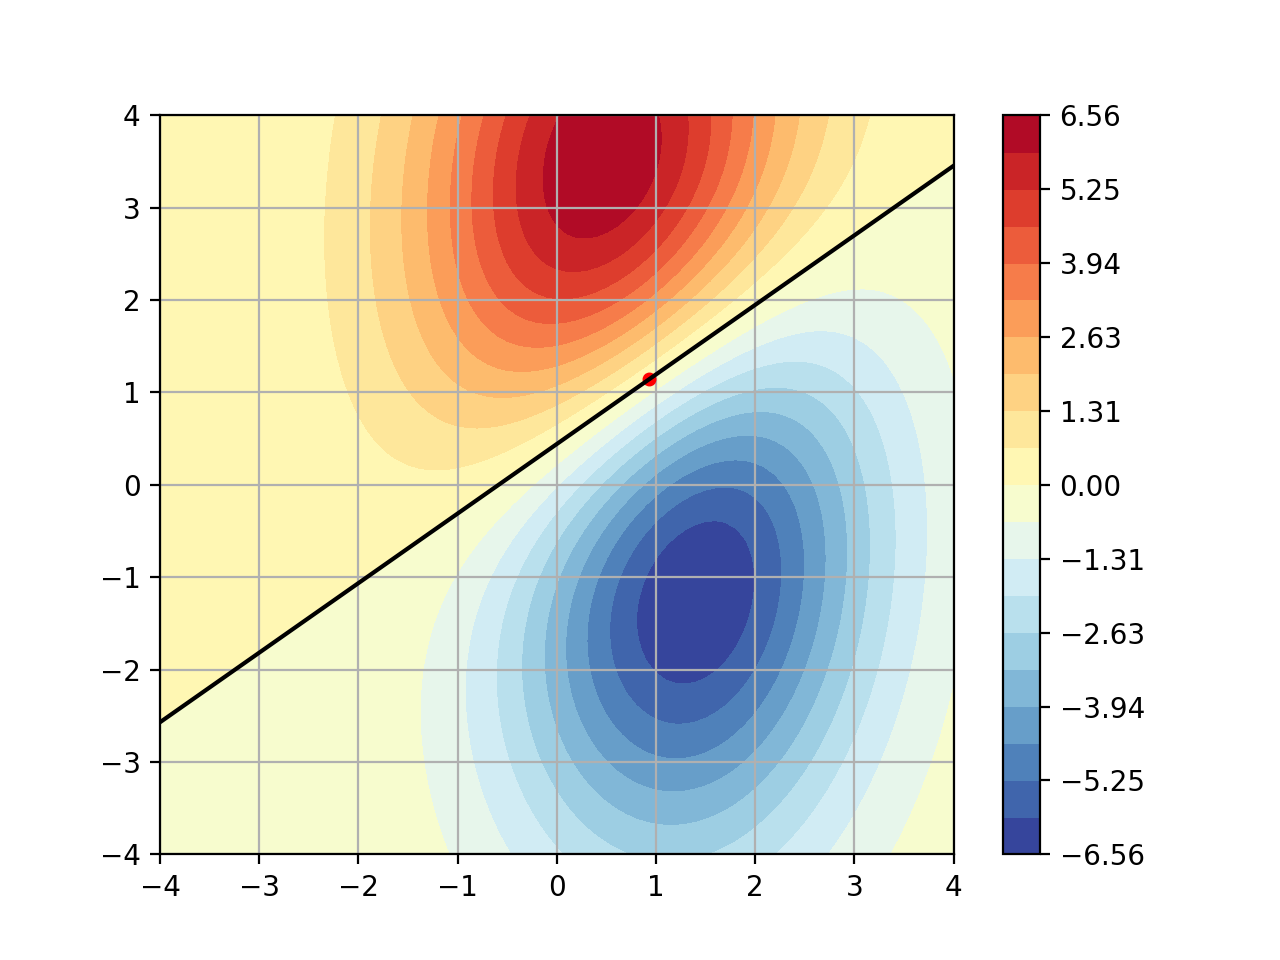

In [25]:
# visualize neuron activity over data space
# extracts the parameters and shows theoritial neuron activity

from matplotlib import cm
# scale of the heat maps
X1 = np.arange(-4,4.1, 0.1)
X2 = np.arange(-4,4.1, 0.1)
X1s, X2s = np.meshgrid(X1,X2)
heatmap_inputs = np.reshape(zip(X1s.flatten(),X2s.flatten()),(-1,2))

# combining circular gaussian with normal neuron
# neuron parameters (weights, bias)
W = model.l1.weights.detach().numpy()[0]
print("weights:",W)
# b = 0 # bias defined by by the center of radial function

# radial parameters
center = model.l1.centers.detach().numpy()[0] # controls the center of gaussian (<=> bias of neuron)
# plot center as red dot
plt.plot(center[0], center[1], marker='o', markersize=4, color="red")

print("center:",center)

b = -np.matmul(W,center)
print("bias:",b)
# new zero line
zero_line = -(W[0]*X1+b)/W[1]

# heatmap neuronal activity
n_activity = np.sum(W*heatmap_inputs, axis=1)+b
# print(n_activity.shape)

distances = heatmap_inputs-center

# heatmap radial activity 
if covar_type == 'sphere':
    inv_covar = model.l1.inv_covar.detach().numpy()[0]
    sig = 1.0/inv_covar
    r_activity = np.exp((-1.0/abs(sig)) *  np.sum(np.square(heatmap_inputs-center), axis=1))
    
elif covar_type == 'diag':
    inv_covar = model.l1.inv_covar.detach().numpy()[0]
    sig = 1.0/inv_covar
    ded = np.einsum('ij,ij->i', distances*abs(inv_covar), distances)
    r_activity = np.exp(-ded)

else:
    inv_covar = model.l1.inv_covar.detach().numpy()[0]
    sig = np.linalg.inv(np.matmul(inv_covar,inv_covar))
    ded = np.einsum('zi,ij,kj,zk->z', distances, inv_covar, inv_covar, distances)
    r_activity = np.exp(-ded)

print("inv covar:", inv_covar)
print("sig:", sig)

    
# overall heatmap activity
activity = n_activity*r_activity

# plot the zero line
plt.plot(X1,zero_line, color='black')
# plot the heatmap 
maxi = np.max(abs(activity))
levels = np.arange(-maxi,maxi+0.1,maxi/10.0)
ticks = np.arange(-maxi,maxi+0.1, maxi/5.0)


plt.contourf(X1s, X2s, np.reshape(activity, np.shape(X1s) ), levels=levels, cmap=cm.RdYlBu_r)

plt.colorbar(ticks=ticks)
#reset axes
plt.axis([-4,4, -4, 4])
plt.grid(True)
plt.show()

In [26]:
# applies the model to get the actual heatmap
# results might be slightly different based on adding a tanh() or not, clipping of output, etc...
# should be close to above
model.eval()
heatmap_inputs = torch.Tensor(heatmap_inputs)
heatmap_preds = model(heatmap_inputs.to(device))
heatmap_preds = heatmap_preds.cpu().detach().numpy()

<IPython.core.display.Javascript object>


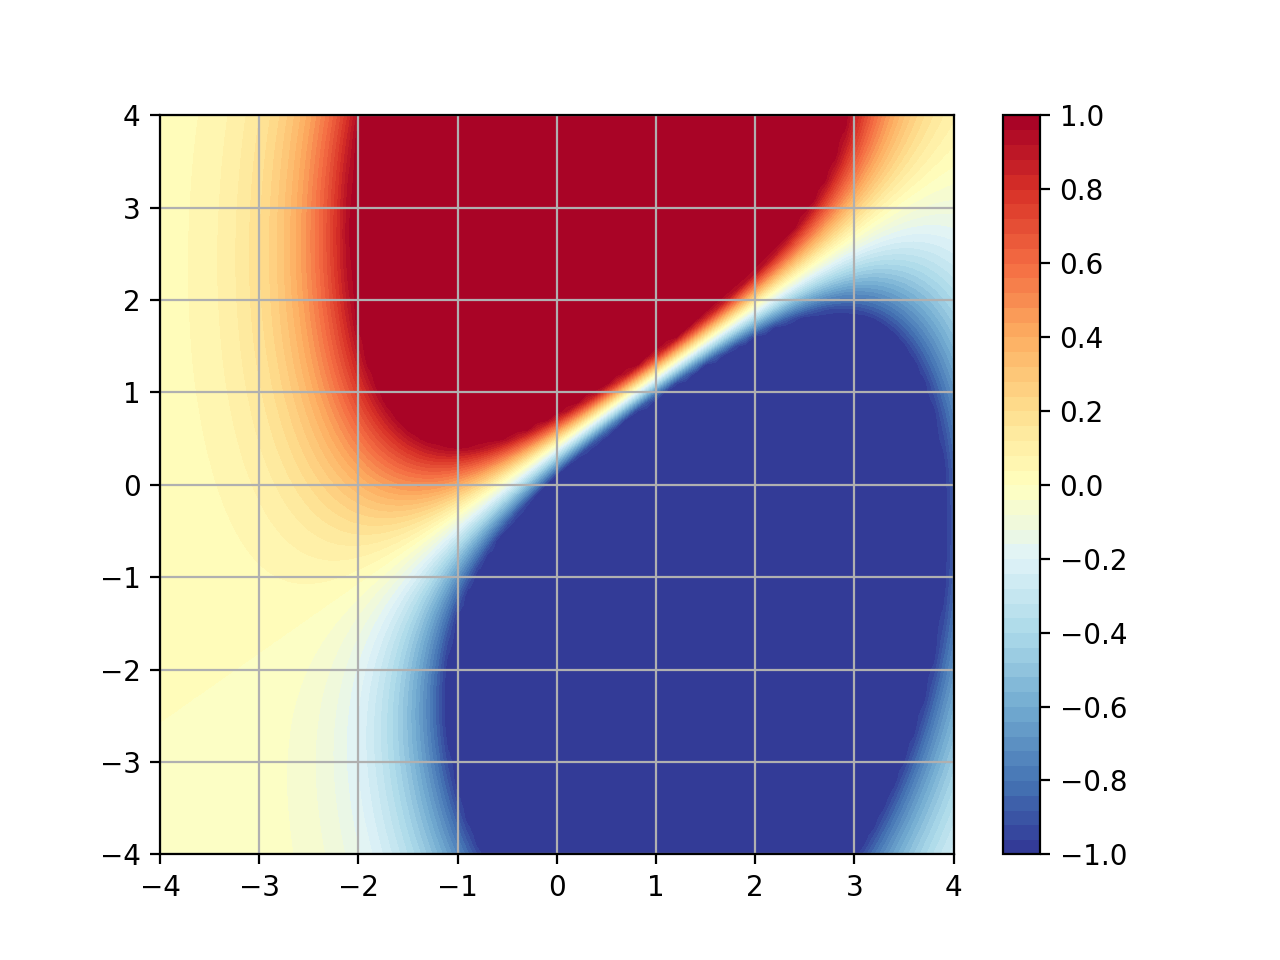

In [27]:
levels = np.arange(-1.0, 1.0+0.001, 5**(-2))
ticks = levels[::5]

plt.contourf(X1s, X2s, np.reshape(heatmap_preds[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
plt.colorbar(ticks=ticks)

# # uncomment if you want to see the data and tighten the window
# plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='gray')
# plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='gray')
# plt.axis([-1.5,2.5, -1, 1.5])

plt.grid(True)
plt.show()